In [1]:
#T006 · Maximum common substructure

In [1]:
from collections import defaultdict
from pathlib import Path
from copy import deepcopy
import random

from ipywidgets import interact, fixed, widgets
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools

#from teachopencadd.utils import seed_everything

#seed_everything()

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
#Load and draw molecules
#Cluster data taken from Talktorial T005 or later MCL1 molecules from Talktorial T001

In [4]:
sdf = str(HERE / "../T000_template/data/molecule_set_largest_cluster.sdf")
supplier = Chem.ForwardSDMolSupplier(sdf)
mols = list(supplier)

print(f"Set with {len(mols)} molecules loaded.")

Set with 34 molecules loaded.


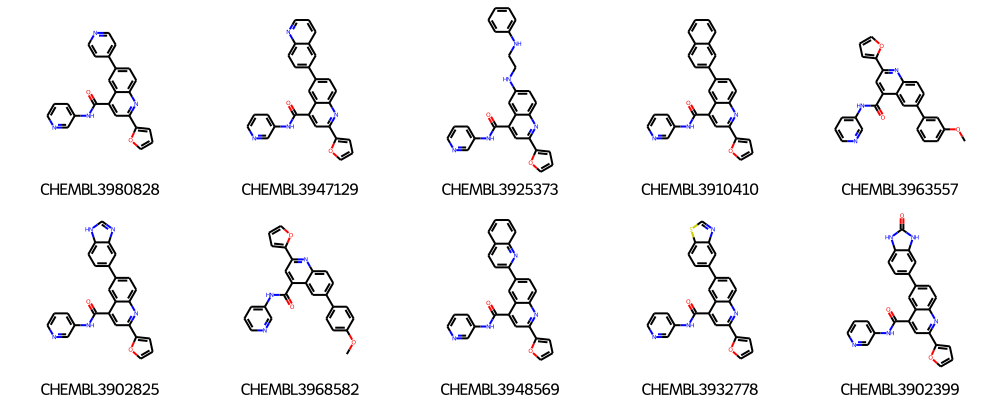

In [5]:
# Show only first 10 molecules -- use slicing
num_mols = 10
legends = [mol.GetProp("_Name") for mol in mols]
Draw.MolsToGridImage(mols[:num_mols], legends=legends[:num_mols], molsPerRow=5)

In [6]:
#Run the FMCS algorithm with different input parameters
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)

MCS1 contains 23 atoms and 25 bonds.
MCS SMARTS string: [#8]=[#6](-[#7]-[#6](:[#6]:[#6]:[#6]):[#6])-[#6]1:[#6]:[#6](-[#6]2:[#6]:[#6]:[#6]:[#8]:2):[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2


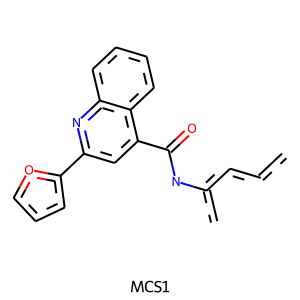

In [7]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

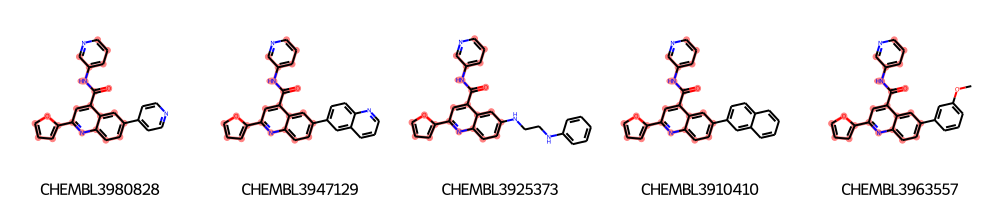

In [8]:
#Define a helper function to draw the molecules with the highlighted MCS
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )
highlight_molecules(mols, mcs1, 5)

In [9]:
#Save image to disk
img = highlight_molecules(mols, mcs1, 3, useSVG=True)

# Get SVG data
molsvg = img.data

# Set background to transparent & Enlarge size of label
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open(DATA / "mcs_largest_cluster.svg", "w") as f:
    f.write(molsvg)

In [10]:
#Set a threshold
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)

MCS2 contains 26 atoms and 29 bonds.
SMARTS string: [#8]=[#6](-[#7]-[#6]1:[#6]:[#6]:[#6]:[#7]:[#6]:1)-[#6]1:[#6]:[#6](-[#6]2:[#6]:[#6]:[#6]:[#8]:2):[#7]:[#6]2:[#6]:1:[#6]:[#6](:[#6]:[#6]:2)-[#6]:[#6]


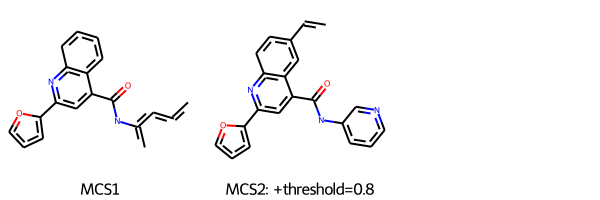

In [11]:
#Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])

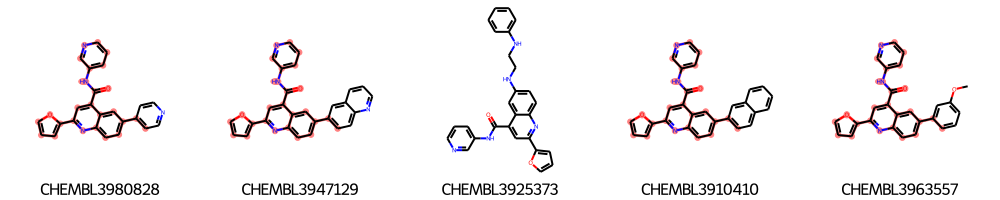

In [12]:
#
highlight_molecules(mols, mcs2, 5)

In [13]:
#Match ring bonds
mcs3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)

MCS3 contains 26 atoms and 29 bonds.
SMARTS string: [#8&!R]=&!@[#6&!R](-&!@[#7&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#7&R]:&@[#6&R]:&@1)-&!@[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#6&R]2:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#8&R]:&@2):&@[#7&R]:&@[#6&R]2:&@[#6&R]:&@1:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@[#6&R]:&@2)-&!@[#6&R]:&@[#6&R]


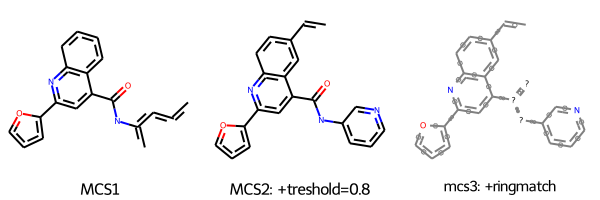

In [14]:
# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

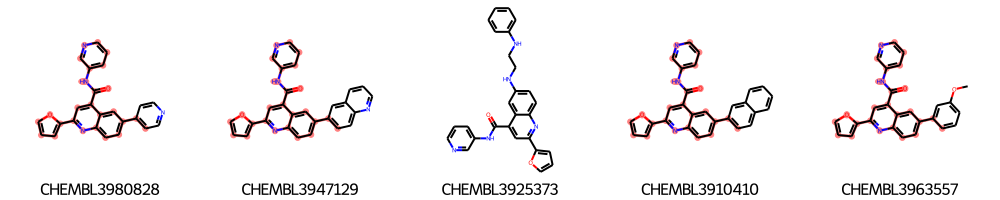

In [15]:
#
highlight_molecules(mols, mcs3, 5)

In [16]:
#A more diverse set: the MCL1 compounds downloaded from ChEMBL
#(restrict the data to only highly active molecules (pIC50>9) and detect the maximum common scaffold in this subset)

In [17]:
# Read full MCL1 data
mol_df = pd.read_csv(HERE / "../T000_template/data/MCL_compounds.csv", index_col=0)
print("Total number of compounds:", mol_df.shape[0])

# Only keep molecules with pIC50 > 9 (IC50 > 1nM)
mol_df = mol_df[mol_df.pIC50 > 9]
print("Number of compounds with pIC50 > 9:", mol_df.shape[0])
# NBVAL_CHECK_OUTPUT

Total number of compounds: 553
Number of compounds with pIC50 > 9: 16


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL4535151,0.2,nM,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,9.69897,
1,CHEMBL4580244,0.2,nM,CN1CC/C=C/[C@H](OCCN2CCS(=O)(=O)CC2)[C@@H]2CC[...,9.69897,
2,CHEMBL4553660,0.2,nM,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,9.69897,

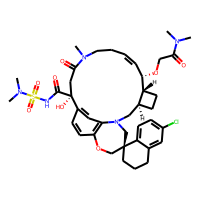
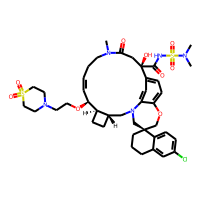
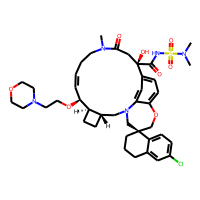

In [18]:
# Add molecule column to data frame
PandasTools.AddMoleculeColumnToFrame(mol_df, "smiles")
mol_df.head(3)

In [19]:
#Do our calculations on the selected highly active molecules only
mols_diverse = []
# Note: discarded variables we do not care about are usually referred to with a single underscore
for _, row in mol_df.iterrows():
    m = Chem.MolFromSmiles(row.smiles)
    m.SetProp("_Name", row.molecule_chembl_id)
    mols_diverse.append(m)

In [20]:
#In the interest of time, we randomly pick 15 molecules from this set.

In [21]:
# We have fixed the random seed above (imports) for deterministic results
mols_diverse_sample = random.sample(mols_diverse, 15)

In [22]:
#We now calculate the same three variants of MCSs as described above and draw the respective substructures. 
#We use a slightly lower threshold to account for the larger diversity in the set.

In [23]:
threshold_diverse = 0.7
mcs1 = rdFMCS.FindMCS(mols_diverse_sample)
print("SMARTS string1:", mcs1.smartsString)
mcs2 = rdFMCS.FindMCS(mols_diverse_sample, threshold=threshold_diverse)
print("SMARTS string2:", mcs2.smartsString)
mcs3 = rdFMCS.FindMCS(mols_diverse_sample, ringMatchesRingOnly=True, threshold=threshold_diverse)
print("SMARTS string3:", mcs3.smartsString)

SMARTS string1: [#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]-[#6]-[#6]-[#6]-[#6]-,:[#6]-,:[#6]:[#6]:[#6](-[#17]):[#6]:,-[#6]:[#6]
SMARTS string2: [#6]-[#8]-[#6]1-[#6]=[#6]-[#6]-[#6]-[#7](-[#6])-[#6](=[#8])-[#6]-[#6](-[#6]2:[#6]:[#6]3-[#7](-[#6]-[#6]4-[#6]-1-[#6]-[#6]-4)-[#6]-[#6]1(-[#6]-[#6]-[#6]-[#6]4:[#6]-1:[#6]:[#6]:[#6](:[#6]:4)-[#17])-[#6]-[#8]-[#6]:3:[#6]:[#6]:2)(-[#8])-[#6](=[#8])-[#7]-[#16](=[#8])=[#8]
SMARTS string3: [#6&!R]-&!@[#8&!R]-&!@[#6&R]1-&@[#6&R]=&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#7&R](-&!@[#6&!R])-&@[#6&R](=&!@[#8&!R])-&@[#6&R]-&@[#6&R](-&@[#6&R]2:&@[#6&R]:&@[#6&R]3-&@[#7&R](-&@[#6&R]-&@[#6&R]4-&@[#6&R]-&@1-&@[#6&R]-&@[#6&R]-&@4)-&@[#6&R]-&@[#6&R]1(-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]4:&@[#6&R]-&@1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@4)-&!@[#17&!R])-&@[#6&R]-&@[#8&R]-&@[#6&R]:&@3:&@[#6&R]:&@[#6&R]:&@2)(-&!@[#8&!R])-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#16&!R](=&!@[#8&!R])=&!@[#8&!R]


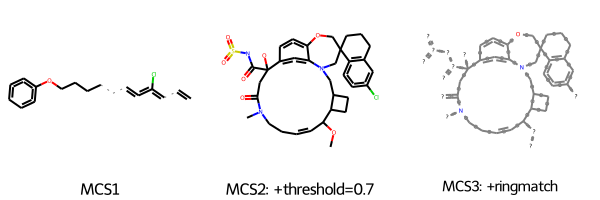

In [24]:
# Draw substructures
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage(
    [m1, m2, m3],
    legends=[
        "MCS1",
        f"MCS2: +threshold={threshold_diverse}",
        "MCS3: +ringmatch",
    ],
)

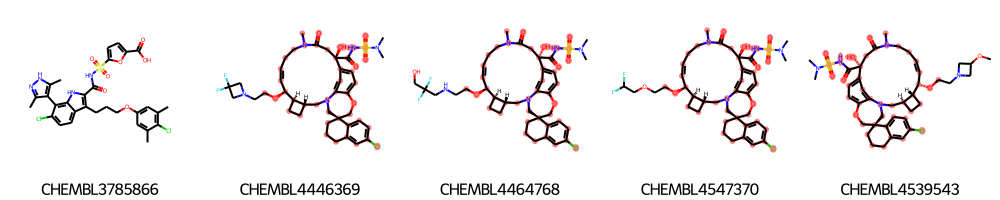

In [25]:
highlight_molecules(mols_diverse_sample, mcs3, 5)

In [26]:
#Identification of MCS using interactive cut-off adaption

In [27]:
def render_mcs(molecules, percentage):
    """Interactive widget helper. `molecules` must be wrapped in `ipywidgets.fixed()`,
    while `percentage` will be determined by an IntSlider widget."""
    tmcs = rdFMCS.FindMCS(molecules, threshold=percentage / 100.0)
    if tmcs is None:
        print("No MCS found")
        return None

    m = Chem.MolFromSmarts(tmcs.smartsString)
    print(tmcs.smartsString)
    return m

In [ ]:
# Note that the slider may take a few seconds to react
interact(
    render_mcs,
    molecules=fixed(mols_diverse_sample),
    percentage=widgets.IntSlider(min=0, max=100, step=10, value=70),
);

interactive(children=(IntSlider(value=70, description='percentage', step=10), Output()), _dom_classes=('widget…